# Test homework solutions to clarify homework documentation

### Import Weak Learners from sklearn, numpy, PIL Image processor, and helper functions

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import glob
import os
from math import log, exp
from time import time
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from copy import deepcopy
from functions import *
import pandas as pd

### Track encodings for reference and run ShallowTree and GaussianNB predictors on both datasets

#### NOTE: Code and documentation for Boost can be found in **functions.py**

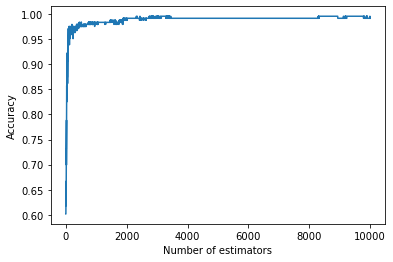

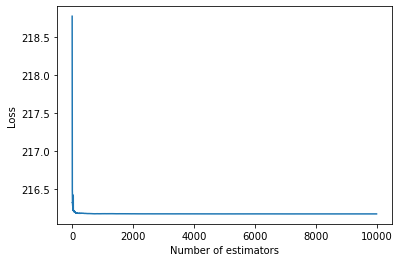

Train accuracy: 99.19% over 10000 trees
Test accuracy: 77.11% over 10000 trees
It took 28.91 seconds to train accent_data over 10000 trees


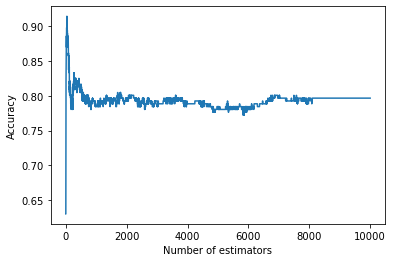

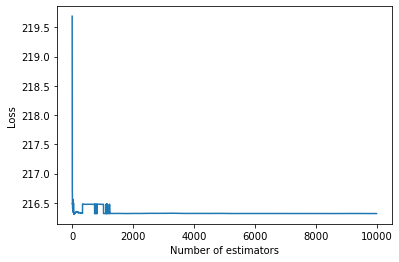

Train accuracy: 79.67% over 10000 naive Bayes
Test accuracy: 71.08% over 10000 naive Bayes
It took 47.44 seconds to train accent_data over 10000 naive Bayes


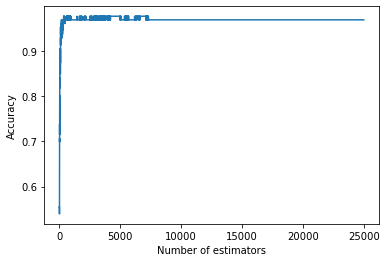

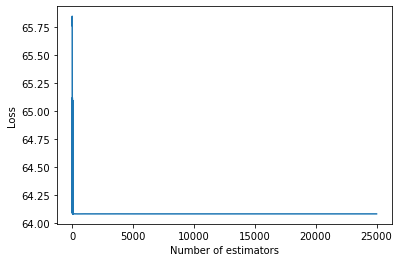

Train accuracy: 96.83% over 25000 trees
Test accuracy: 34.88% over 25000 trees
It took 41.34 seconds to train deepfakes_data over 25000 trees


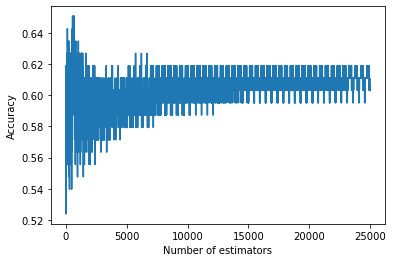

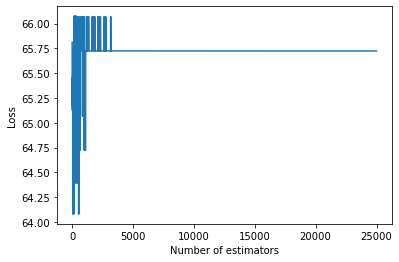

Train accuracy: 60.32% over 25000 naive Bayes
Test accuracy: 34.88% over 25000 naive Bayes
It took 74.11 seconds to train deepfakes_data over 25000 naive Bayes
Test completed after 191.81 seconds


In [6]:
encodings = {}
hard_start = time()
for data_dir in ("data/Homework/Accent_Recognition/accent_data.csv", "data/Homework/Medical_Deepfakes/deepfakes_data.csv",):
    data_name = data_dir.split('/')[-1][0:-4]
    df = pd.read_csv(data_dir)
    Y = df.iloc[:,0].to_numpy()
    if type(Y[0]) is str:
        le = LabelEncoder().fit(Y)
        encoding = dict()
        for cl_ in le.classes_:
            encoding[cl_] = le.transform([cl_])[0]
        encodings[data_name] = encoding
        Y = le.transform(Y)
        df.iloc[:,0] = Y
    X = df.iloc[:,1:].to_numpy()
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y)
    if data_name == "accent_data":
        n_estimators = 10000
    elif data_name == "deepfakes_data":
        n_estimators = 25000
    start = time()
    v = None
    booster_update2 = Boost(n_estimators = n_estimators, base_learner=DecisionTreeClassifier(max_depth=2)).update_fit(Xtrain,Ytrain, verbose=v)
    print(f"Train accuracy: {booster_update2.accuracy(booster_update2.predict(Xtrain), Ytrain):.2%} over {n_estimators} trees")
    print(f"Test accuracy: {booster_update2.accuracy(booster_update2.predict(Xtest),Ytest):.2%} over {n_estimators} trees")
    print(f"It took {time()-start:.2f} seconds to train {data_name} over {n_estimators} trees")
    
    start=time()
    v=None
    booster_update2 = Boost(n_estimators = n_estimators, base_learner=GaussianNB()).update_fit(Xtrain,Ytrain, verbose=v)
    print(f"Train accuracy: {booster_update2.accuracy(booster_update2.predict(Xtrain), Ytrain):.2%} over {n_estimators} naive Bayes")
    print(f"Test accuracy: {booster_update2.accuracy(booster_update2.predict(Xtest),Ytest):.2%} over {n_estimators} naive Bayes")
    print(f"It took {time()-start:.2f} seconds to train {data_name} over {n_estimators} naive Bayes")

print(f"Test completed after {time()-hard_start:.2f} seconds")